# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████████████| 60.0K/60.0K [02:41<00:00, 372File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

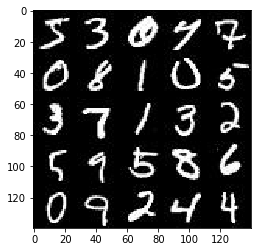

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

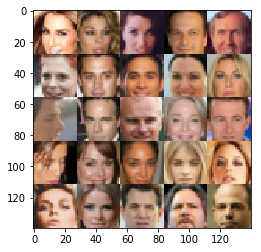

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


D:\Program Files\Anaconda3\envs\dlnd\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    # real_dim = (image_width, image_height, image_channels)
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='SAME')
        x1 = tf.maximum(alpha*x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(x1, 64, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        # 7x7x64
        
        x3 = tf.layers.conv2d(x2, 128, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        # 4x4 128
        
        flat = tf.reshape(x3, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [41]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*128)
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 7x7x128
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 14x14x64
        
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # 28x28x32
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='SAME')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [42]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [47]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [53]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_w, img_h, img_d = data_shape
    input_real, input_z, lr = model_inputs(img_w, img_h, img_d, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, img_d)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()

    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    figsize=(5,5)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2 # [-0.5, 0.5] to [-1, 1]
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, img_d, data_image_mode)

        saver.save(sess, './generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3901... Generator Loss: 1.6362
Epoch 1/2... Discriminator Loss: 0.1304... Generator Loss: 7.0885
Epoch 1/2... Discriminator Loss: 1.1292... Generator Loss: 0.7767
Epoch 1/2... Discriminator Loss: 0.4315... Generator Loss: 1.7974
Epoch 1/2... Discriminator Loss: 0.7560... Generator Loss: 1.2289
Epoch 1/2... Discriminator Loss: 0.9524... Generator Loss: 0.8671
Epoch 1/2... Discriminator Loss: 1.1225... Generator Loss: 1.5057
Epoch 1/2... Discriminator Loss: 1.5197... Generator Loss: 1.5395
Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 1.2986
Epoch 1/2... Discriminator Loss: 1.7467... Generator Loss: 2.1255


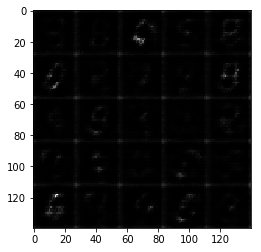

Epoch 1/2... Discriminator Loss: 1.1880... Generator Loss: 1.0919
Epoch 1/2... Discriminator Loss: 1.0545... Generator Loss: 1.1934
Epoch 1/2... Discriminator Loss: 1.2610... Generator Loss: 0.5062
Epoch 1/2... Discriminator Loss: 1.0863... Generator Loss: 0.7486
Epoch 1/2... Discriminator Loss: 1.1560... Generator Loss: 0.6122
Epoch 1/2... Discriminator Loss: 1.3494... Generator Loss: 0.4484
Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.4389
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 1.2647
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 2.0966
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 0.6145


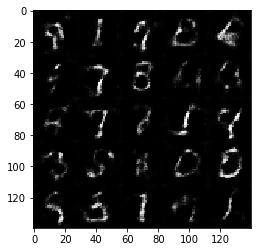

Epoch 1/2... Discriminator Loss: 1.0245... Generator Loss: 0.8223
Epoch 1/2... Discriminator Loss: 0.9432... Generator Loss: 1.2055
Epoch 1/2... Discriminator Loss: 1.2322... Generator Loss: 0.5834
Epoch 1/2... Discriminator Loss: 1.0615... Generator Loss: 0.7187
Epoch 1/2... Discriminator Loss: 1.5270... Generator Loss: 2.0289
Epoch 1/2... Discriminator Loss: 1.0452... Generator Loss: 1.2314
Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 1.5108
Epoch 1/2... Discriminator Loss: 1.0933... Generator Loss: 0.7224
Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 0.6258
Epoch 1/2... Discriminator Loss: 1.3361... Generator Loss: 0.4537


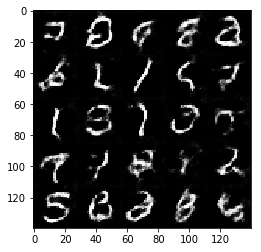

Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.1506... Generator Loss: 0.6555
Epoch 1/2... Discriminator Loss: 1.0764... Generator Loss: 0.8512
Epoch 1/2... Discriminator Loss: 1.3511... Generator Loss: 1.3628
Epoch 1/2... Discriminator Loss: 1.4658... Generator Loss: 1.7500
Epoch 1/2... Discriminator Loss: 1.2547... Generator Loss: 0.5180
Epoch 1/2... Discriminator Loss: 1.0581... Generator Loss: 1.7806
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 0.8763
Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 1.0534... Generator Loss: 1.6997


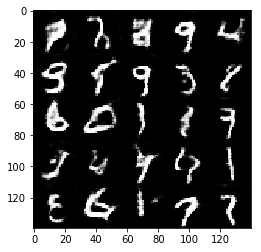

Epoch 1/2... Discriminator Loss: 1.0438... Generator Loss: 1.1534
Epoch 1/2... Discriminator Loss: 0.8603... Generator Loss: 1.0064
Epoch 1/2... Discriminator Loss: 1.0274... Generator Loss: 1.5548
Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 0.7369
Epoch 1/2... Discriminator Loss: 1.1312... Generator Loss: 1.6996
Epoch 1/2... Discriminator Loss: 1.0203... Generator Loss: 1.2106
Epoch 2/2... Discriminator Loss: 1.0779... Generator Loss: 1.3466
Epoch 2/2... Discriminator Loss: 0.8688... Generator Loss: 1.0467
Epoch 2/2... Discriminator Loss: 1.1254... Generator Loss: 0.5743
Epoch 2/2... Discriminator Loss: 1.0459... Generator Loss: 0.7522


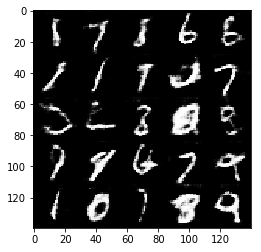

Epoch 2/2... Discriminator Loss: 0.8165... Generator Loss: 1.2201
Epoch 2/2... Discriminator Loss: 1.4192... Generator Loss: 0.4053
Epoch 2/2... Discriminator Loss: 0.9685... Generator Loss: 0.7806
Epoch 2/2... Discriminator Loss: 1.0914... Generator Loss: 0.7354
Epoch 2/2... Discriminator Loss: 0.9528... Generator Loss: 1.3990
Epoch 2/2... Discriminator Loss: 0.9152... Generator Loss: 1.0263
Epoch 2/2... Discriminator Loss: 0.9015... Generator Loss: 0.9651
Epoch 2/2... Discriminator Loss: 1.0872... Generator Loss: 1.0709
Epoch 2/2... Discriminator Loss: 1.3501... Generator Loss: 0.4214
Epoch 2/2... Discriminator Loss: 1.1161... Generator Loss: 0.6795


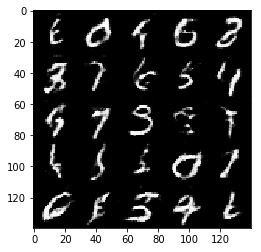

Epoch 2/2... Discriminator Loss: 1.4520... Generator Loss: 0.4088
Epoch 2/2... Discriminator Loss: 1.0265... Generator Loss: 0.8027
Epoch 2/2... Discriminator Loss: 1.0219... Generator Loss: 0.8014
Epoch 2/2... Discriminator Loss: 1.1475... Generator Loss: 0.6503
Epoch 2/2... Discriminator Loss: 1.1967... Generator Loss: 0.6203
Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 0.6353
Epoch 2/2... Discriminator Loss: 0.9536... Generator Loss: 1.4408
Epoch 2/2... Discriminator Loss: 1.0762... Generator Loss: 0.7172
Epoch 2/2... Discriminator Loss: 0.8286... Generator Loss: 1.2347
Epoch 2/2... Discriminator Loss: 1.0178... Generator Loss: 0.7840


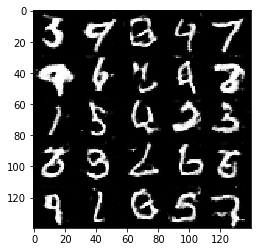

Epoch 2/2... Discriminator Loss: 1.0764... Generator Loss: 0.7583
Epoch 2/2... Discriminator Loss: 0.9456... Generator Loss: 0.9225
Epoch 2/2... Discriminator Loss: 0.9484... Generator Loss: 1.6489
Epoch 2/2... Discriminator Loss: 0.9272... Generator Loss: 0.9445
Epoch 2/2... Discriminator Loss: 1.0857... Generator Loss: 0.7510
Epoch 2/2... Discriminator Loss: 0.9118... Generator Loss: 1.5751
Epoch 2/2... Discriminator Loss: 0.9279... Generator Loss: 0.8503
Epoch 2/2... Discriminator Loss: 1.1825... Generator Loss: 0.7822
Epoch 2/2... Discriminator Loss: 0.7961... Generator Loss: 1.0113
Epoch 2/2... Discriminator Loss: 1.0481... Generator Loss: 1.1131


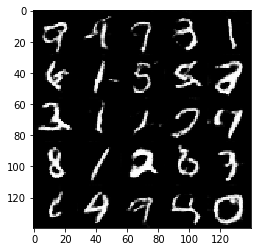

Epoch 2/2... Discriminator Loss: 1.3681... Generator Loss: 0.4509
Epoch 2/2... Discriminator Loss: 0.9010... Generator Loss: 1.1879
Epoch 2/2... Discriminator Loss: 1.1713... Generator Loss: 0.5168
Epoch 2/2... Discriminator Loss: 1.0535... Generator Loss: 0.9448
Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 0.6740
Epoch 2/2... Discriminator Loss: 1.1894... Generator Loss: 0.5388
Epoch 2/2... Discriminator Loss: 1.1564... Generator Loss: 0.6784
Epoch 2/2... Discriminator Loss: 1.3916... Generator Loss: 2.1600
Epoch 2/2... Discriminator Loss: 0.8919... Generator Loss: 1.5522


KeyboardInterrupt: 

In [54]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6681... Generator Loss: 5.3824
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 6.4169
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 2.3063
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 0.9025


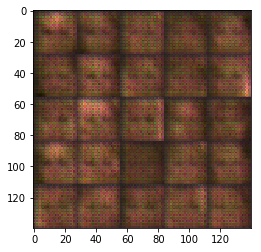

Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 1.2077
Epoch 1/1... Discriminator Loss: 0.2766... Generator Loss: 3.4570
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 1.3124


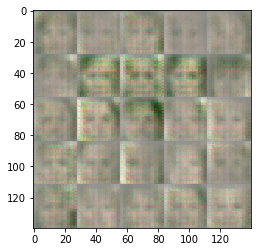

Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 0.5417... Generator Loss: 2.1834
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 1.2072
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.5946


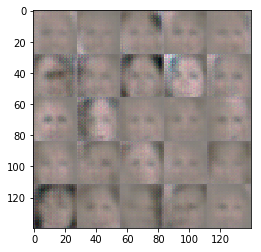

Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 1.3544
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 2.4936


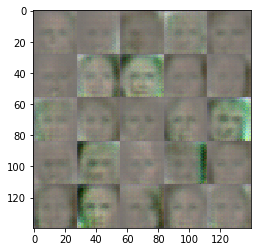

Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.7593
Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 1.2170
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.8986


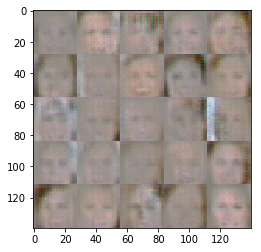

Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 1.8436
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 0.6907


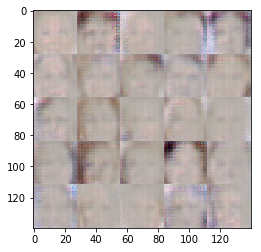

Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 0.6831... Generator Loss: 1.6774
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 2.9889
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 1.9164


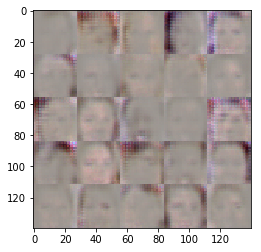

Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.5288
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.3784
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.5371


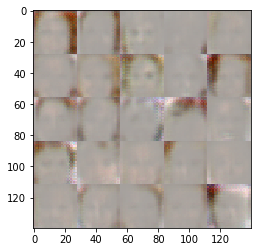

Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 1.9151
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 0.6686... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 1.6848


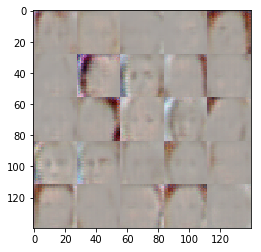

Epoch 1/1... Discriminator Loss: 2.3337... Generator Loss: 0.1435
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 0.8761


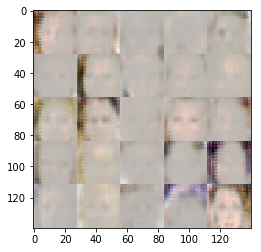

Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 1.4316
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.4794


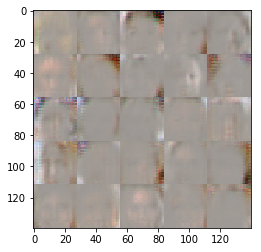

Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.5401
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.4439
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.6371


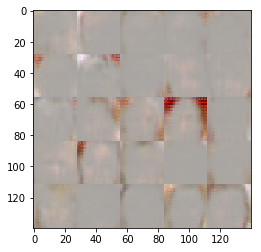

Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 0.7539... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.5211


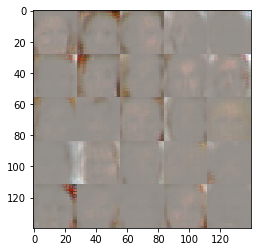

Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.3391
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.7481... Generator Loss: 0.3303
Epoch 1/1... Discriminator Loss: 0.7093... Generator Loss: 1.7954


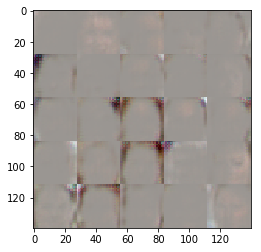

Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 1.7003... Generator Loss: 2.4798
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 1.0571
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.2079


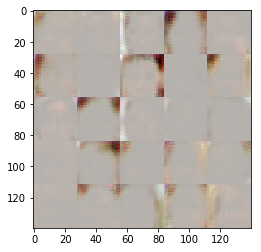

Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 1.3622
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.8106


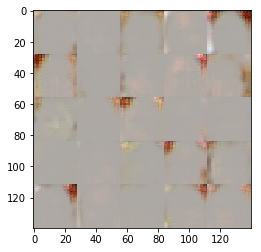

Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.6211... Generator Loss: 0.3454
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.5715
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.6058


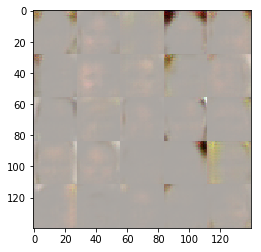

Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.5479
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 0.9714
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 1.1489


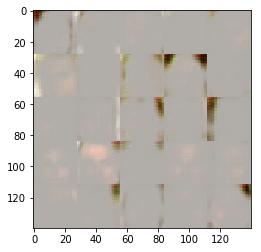

Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 1.2861


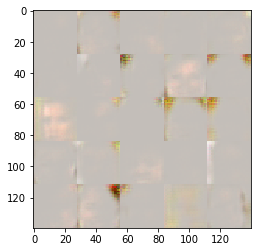

Epoch 1/1... Discriminator Loss: 1.6089... Generator Loss: 0.3117
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 1.9407... Generator Loss: 0.2233
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.6728


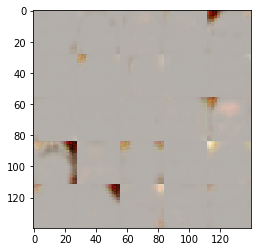

Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 1.3749
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 1.1117
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 1.2149
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 1.0775


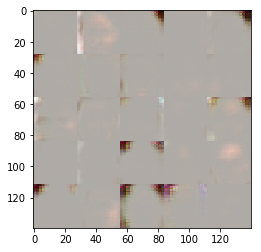

Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.4136
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.8533


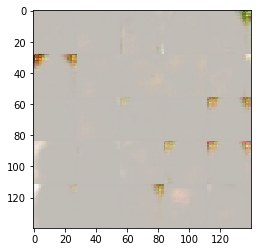

Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.1979
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.5556
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.4296


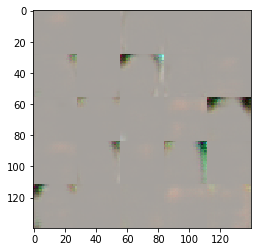

Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.9750


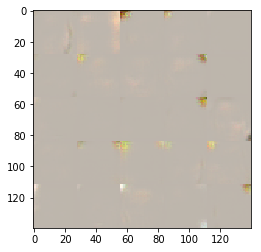

Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.8948


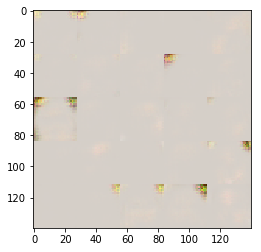

Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.1424
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 1.0600


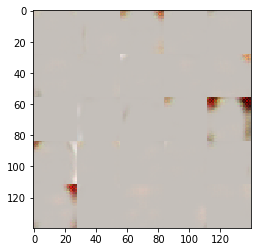

Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.4038
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.5911
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.9241


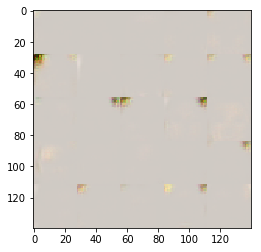

Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.4846
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 0.7356


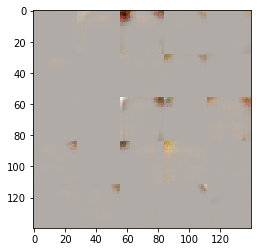

Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.7371


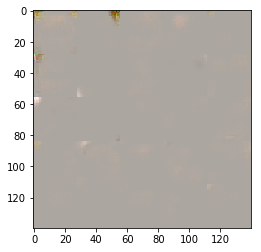

Epoch 1/1... Discriminator Loss: 1.6845... Generator Loss: 0.2739
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 1.5886
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.0675


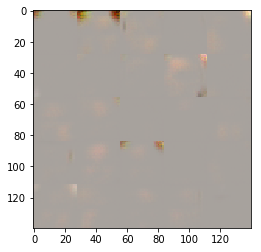

Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 1.4969
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 1.0511


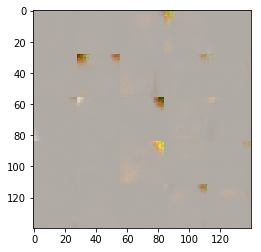

Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 1.0285
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 1.5078


ValueError: Parent directory of ./checkpoints/generator.ckpt doesn't exist, can't save.

In [39]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.